# Load Data: 2 images in, 1 mask out

Prepare data for when 2 images are input into the model, and the output is a multi-label segmentation mask that informs where the features are and the damange level they have.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export 
from xview2comp.nb_01 import *

In [405]:
SOURCE = Path('data/')

In [6]:
bs = 4

In [7]:
fnames = get_files(SOURCE/'train'/'train'/'images', extensions=['.png',])

### Damage levels: `str`s to `int`s

In [143]:
#export
class DamageCategorize():
    def __init__(self):
        self.o2i = {'un-classified':1, 'no-damage':1, 'minor-damage':2, 'major-damage':3, 'destroyed':4}
    def __call__(self, o): return self.o2i[o]

In [144]:
damgcats = DamageCategorize()
damgcats('minor-damage'), damgcats('un-classified')

(2, 1)

### Get damage level mask

The target mask will consist of polygons from the pre-disaster `.json` file and damage levels from the post-disaster `.json` file.

In [16]:
npreimgs = pre_img_fpaths(fnames)
len(prefns), len(fnames)

(2799, 5598)

In [17]:
nposimgs = [pre2post_fpath(o) for o in prefns]
len(posfns)

2799

In [85]:
def load_features(n:Path): return json.load(open(n))['features']['xy']

In [160]:
def polys2mask(polys, labes=None, sz=(1024, 1024)):
    '''Write polygons to a mask using their given labels.'''
    if not labes: labes = len(polys) * [1,]
    assert len(polys) == len(labes)
    polys = [shapely.geometry.mapping(p) for p in polys]
    polys = [np.array(p['coordinates'][0], dtype=np.int32) for p in polys]
    mask = np.zeros(sz, dtype=np.uint8)
    for p, l in zip(polys, labes):
        p = np.array([p])
        cv2.fillPoly(mask, p, (l,))
    return mask

In [213]:
def img2damgmask(o:Path):
    ''' Transform image path to multi-label mask, where 0= no feature, 1 = , ..., etc. 
    o: path to the pre-disaster image.
    '''
    nprelab = img2label_fpath(o)
    nposlab = pre2post_fpath(nprelab)
    fprelab, fposlab = load_features(nprelab), load_features(nposlab)
    fposlab = [fpos for fpre in fprelab for fpos in fposlab if fpos['properties']['uid']==fpre['properties']['uid']]
    if len(fposlab) != len(fprelab): raise Exception('Pre-disaster and post-disaster uids do not match.')
    
    polys = feats2polys(fprelab)
    damgs = [o['properties']['subtype'] for o in fposlab]
    labs = list(map(DamageCategorize(), damgs))
                
    mask0, mask = polys2mask(polys), polys2mask(polys, labs)
    mask = np.ma.masked_array(mask, mask=(mask0 > 1))
    mask = np.ma.filled(mask, fill_value=0)
    return mask

In [214]:
mask = img2damgmask(npreimgs[78])
mask

array([[0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0]], dtype=uint8)

In [215]:
np.unique(mask)

array([0, 1, 2, 3, 4], dtype=uint8)

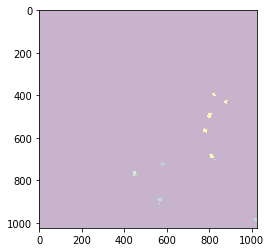

In [221]:
plt.imshow(mask, alpha=.3);

In [224]:
np.allclose(np.array(PIL.Image.fromarray(mask)), mask)

True

### Saving and loading damage mask

In [226]:
save_mask(mask, 'testsave_damagemask.png')

In [229]:
np.allclose(load_mask('testsave_damagemask.png'), mask)

True

### Produce damage mask for all samples

In [232]:
os.makedirs('data/train/train/damagemasks')

In [276]:
(SOURCE/'train'/'train').ls()

[PosixPath('data/train/train/images'),
 PosixPath('data/train/train/damagemasks'),
 PosixPath('data/train/train/labels'),
 PosixPath('data/train/train/binarymasks')]

In [241]:
def img2damgmask_fpath(n): 
    return str(n).replace('images/', 'damagemasks/').replace('_pre_', '_')

In [245]:
def generate_damagemasks(fnames):
    for n in fnames:
        mask = img2damgmask(n)
        fpath = img2damgmask_fpath(n)
        PIL.Image.fromarray(mask).save(fpath)

**Run this cell below to generate the damage mask for all samples in the training set**

In [272]:
#%%time

#generate_damagemasks(npreimgs)

CPU times: user 5min 1s, sys: 4.29 s, total: 5min 5s
Wall time: 5min 20s


In [275]:
len((SOURCE/'train'/'train'/'damagemasks').ls()), len(npreimgs)

(2799, 2799)

In [268]:
fname = (SOURCE/'train'/'train'/'damagemasks').ls()[1]
fname

PosixPath('data/train/train/damagemasks/hurricane-harvey_00000228_disaster.png')

In [269]:
loaded_mask = np.array(PIL.Image.open(fname))

In [267]:
npreimgs[1]

PosixPath('data/train/train/images/hurricane-harvey_00000228_pre_disaster.png')

In [270]:
mask = img2damgmask(npreimgs[1])

In [271]:
np.allclose(mask, loaded_mask)

True

In [264]:
'_'.join(npreimgs[2].stem.split('_')[:2])

'hurricane-michael_00000261'

### *Pre-disaster image + post-disaster image* as model input

In [282]:
idx = 19

In [283]:
npreimgs[idx]

PosixPath('data/train/train/images/socal-fire_00001344_pre_disaster.png')

In [284]:
pre2post_fpath(npreimgs[idx])

PosixPath('data/train/train/images/socal-fire_00001344_post_disaster.png')

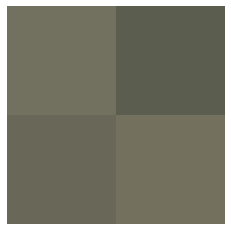

In [334]:
pretfms = [PIL.Image.open, ResizeFixed(2, resample=PIL.Image.BILINEAR), to_byte_tensor, to_float_tensor, Normalize(1/255)]
preimg = compose(npreimgs[idx], pretfms)
show_sample(preimg);

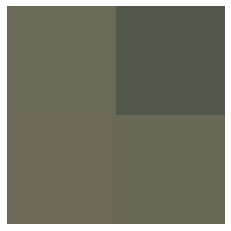

In [335]:
postfms = pretfms[:]
posimg = compose(nposimgs[idx], postfms)
show_sample(posimg);

In [338]:
preimg

tensor([[[0.4471, 0.3569],
         [0.4118, 0.4510]],

        [[0.4392, 0.3647],
         [0.4078, 0.4431]],

        [[0.3725, 0.3059],
         [0.3451, 0.3647]]])

In [337]:
torch.cat([preimg, posimg], dim=0)

tensor([[[0.4471, 0.3569],
         [0.4118, 0.4510]],

        [[0.4392, 0.3647],
         [0.4078, 0.4431]],

        [[0.3725, 0.3059],
         [0.3451, 0.3647]],

        [[0.4157, 0.3216],
         [0.4196, 0.4039]],

        [[0.4157, 0.3451],
         [0.4078, 0.4078]],

        [[0.3412, 0.2941],
         [0.3412, 0.3333]]])

Can't really use `ImageList` here because its `get` method opens just one image file.  Need to go further back to the pre-disaster image file name, get the corrsponding post-disaster image file name, and proceed from there.  Since the transforms in taking an image file name to a normalized float tensor are the same for both the pre-disaster and post-disaster image, they can be simply looped over these two images, and this is done with `TupleTransform` which applies the same transform(s) to every element of a tuple.  

In [342]:
class TupleTransform():
    def __init__(self, funcs): 
        if not isinstance(funcs, list): funcs = [funcs]
        self.funcs = funcs
    def __call__(self, xs):
        return tuple(compose(x, self.funcs) for x in xs)

In [343]:
def get_imgpaths(n): return n, pre2post_fpath(n)

In [382]:
def concat_channels(imgs): return torch.cat(imgs, dim=0)

In [401]:
tfms_imgs = [PIL.Image.open, ResizeFixed(516, resample=PIL.Image.BILINEAR), to_byte_tensor, to_float_tensor,
             Normalize(1/255)]

xtfms = [get_imgpaths, TupleTransform(tfms_imgs), concat_channels]

il = ItemList(npreimgs, tfms=xtfms)

In [404]:
il[11].shape

torch.Size([6, 516, 516])

###  `LabeledData` 

The damage mask for each sample has already been produced and saved to disk above.  The label in this case is the path  to the damage mask.  Then, the transforms are just those that will convert the damage mask path to a float tensor.

In [611]:
idx = 700

In [408]:
il.items[idx]

PosixPath('data/train/train/images/hurricane-michael_00000287_pre_disaster.png')

In [409]:
img2damgmask_fpath(il.items[idx])

'data/train/train/damagemasks/hurricane-michael_00000287_disaster.png'

In [448]:
sz = 516

tfms_imgs = [PIL.Image.open, ResizeFixed(sz, resample=PIL.Image.BILINEAR), to_byte_tensor, to_float_tensor, Normalize(1/255)]
xtfms = [get_imgpaths, TupleTransform(tfms_imgs), concat_channels]
il = ItemList(npreimgs, tfms=xtfms)
sd = SplitData.split_by_random(il, val_pct=.1)

ytfms = [ResizeFixed(sz, resample=PIL.Image.NEAREST), to_byte_tensor, to_float_tensor]
ll = label_by_func(sd, img2damgmask_fpath, listtype=ImageList, tfms=ytfms)


In [615]:
idx = 165
x, y = ll.train.x[idx], ll.train.y[idx]

In [609]:
x.shape, y.shape, y.dtype, y.unique()

(torch.Size([6, 516, 516]),
 torch.Size([1, 516, 516]),
 torch.float32,
 tensor([0.]))

Shapes and values look promising.  Again, plotting is a good way to double-check.  Since there are now 5 categories in the mask, 5 distinctive colours are needed.  `matplotlib` has some built in color maps, but `matplotlib.colors.ListedColormap` can be used to create a color map from a list of colours.  Pick no colour for where there is no feature at all.  *Blue* for `un-classified` or `no damage`; *cyan* for `minor damage`; *orange* for `major damage`; and *red* for `destroyed`.

In [494]:
a = np.array([[0., 1, 3],
              [2, 4, 1]], dtype=np.float32)
a.dtype

dtype('float32')

In [602]:
import matplotlib.colors as colors
CMAP = colors.ListedColormap(['None', 'b', 'c', 'orange', 'r'])

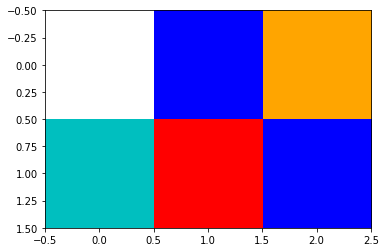

In [601]:
plt.imshow(a, cmap=CMAP);

The `show_sample` is also updated to handle multiple input images, each of which will be overlaid with the input mask.  Note that with this definition, plotting a binary mask over an image will only produce a plot where the features are coloured blue, whereas they used to be coloured red.

In [592]:
def show_sample(*imgs, mas=None, figsize=(4, 4)):
    _, axs = plt.subplots(nrows=1, ncols=len(imgs), figsize=figsize)
    for ax, img in zip(np.array([axs]).flatten(), imgs):
        ax.axis('off')
        ax.imshow(img.permute(1, 2, 0))
        if mas is not None:
            ax.imshow(mas[0], cmap=CMAP, alpha=.4)

Notice below that the pre-disaster and post-disaster images are not perfectly aligned (the masks are aligned because they are the same mask).

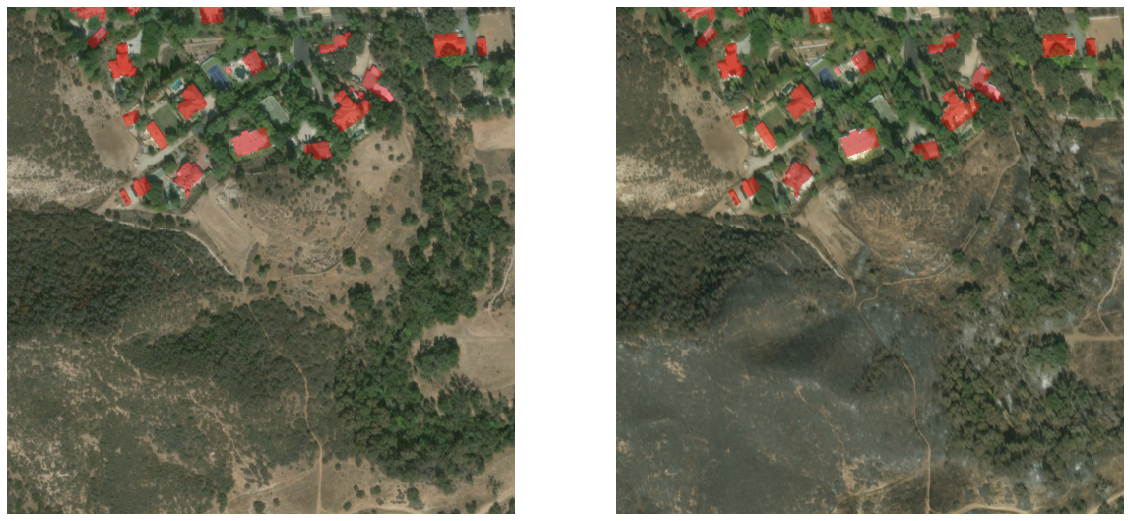

In [616]:
show_sample(x[:3], x[3:], mas=y, figsize=(20, 10))

# - fin

In [ ]:
! python notebook2script.py 01b_load_data_2in1out.ipynb